<a href="https://colab.research.google.com/github/jonbmartin/Gradient-Waveform-Errors-Demos/blob/main/Ex1_Eddy_Currents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

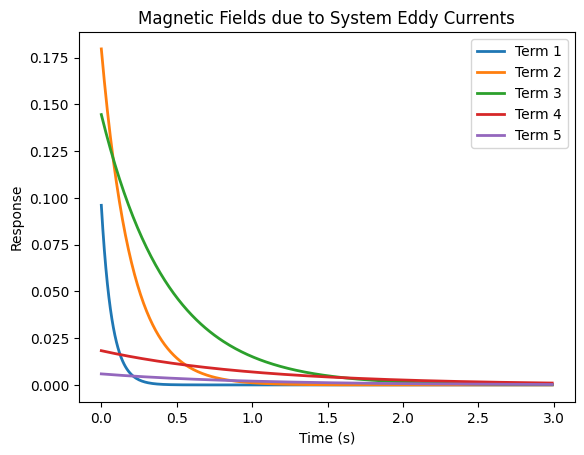

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
gts = 10e-6      # gradient time delay [s]
num_terms = 5    # number of exponential terms in impulse response
tau = np.array([7.0, 19.8, 44.3, 102.9, 93.3]) / 100000 # time constants for the exponential decay terms [s]
coeffs = np.array([9.60, 17.96, 14.45, 1.83, 0.59]) / 100 # coefficients for the exponential terms [% of pulsed field]
t_model = np.arange(0, 300 * gts, gts)

# Generate multi-exponential eddy current impulse response function.
# Each term represents the magnetic eddy current fields induced by a structural component of the MRI system
eps = np.zeros_like(t_model)
eps_terms = np.zeros((5, np.size(t_model)))
for i in range(num_terms):
    eps_terms[i,:] = coeffs[i] * np.exp(-t_model / tau[i])
    eps += eps_terms[i,:]

for i in range(num_terms):
    plt.plot(t_model * 1e3, coeffs[i] * np.exp(-t_model / tau[i]), label=f'Term {i+1}', linewidth=2)
plt.title('Magnetic Fields due to System Eddy Currents')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()
plt.show()


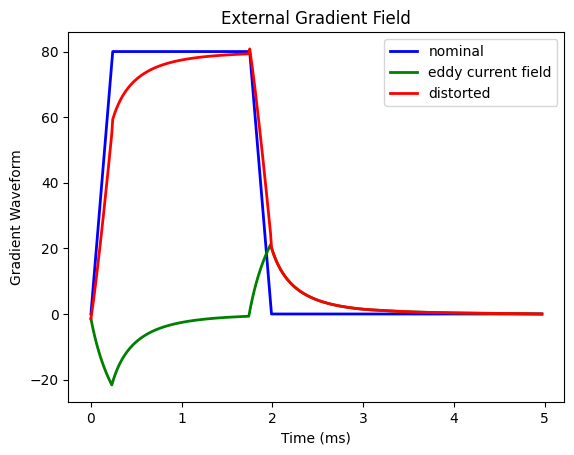

In [6]:
# Build a simple trapezoidal gradient
nramp = 25
nconst = 150
B_ext_norm = np.concatenate((np.linspace(0, 1, nramp), np.ones(nconst), np.linspace(1, 0, nramp)))
B_ext = B_ext_norm * 80
S_ext = np.diff(B_ext)
t_grad = np.arange(0, np.size(B_ext)*gts, gts)

# Convolve with external magnetic field to simulate eddy currents
B0_eddy = np.convolve(-S_ext, eps, mode='full')

# Find the combined gradient amplitude
B_net = B0_eddy + np.pad(B_ext, (0, len(B0_eddy) - len(B_ext)))
t_grad_distorted = np.arange(0, np.size(B_net)*gts, gts)
# Plot results
B_ext_norm = np.pad(B_ext, (0, len(B0_eddy) - len(B_ext)))

plt.plot(t_grad_distorted * 1e3, B_ext_norm, 'b', linewidth=2)
plt.plot(t_grad_distorted * 1e3, B0_eddy, 'g', linewidth=2)
plt.plot(t_grad_distorted * 1e3, B_net, 'r', linewidth=2)

plt.legend(['nominal', 'eddy current field', 'distorted'])
plt.plot()
plt.title('External Gradient Field')
plt.xlabel('Time (ms)')
plt.ylabel('Gradient Waveform')
plt.show()


Ok, what if we would like to prospectively correct for these eddy currents? Pre-emphasis (sometimes also called pre-compensation or pre-distortion) is a method for doing so.

To achieve prospective correction, we intentionally distort the gradients to counter the known eddy currents.

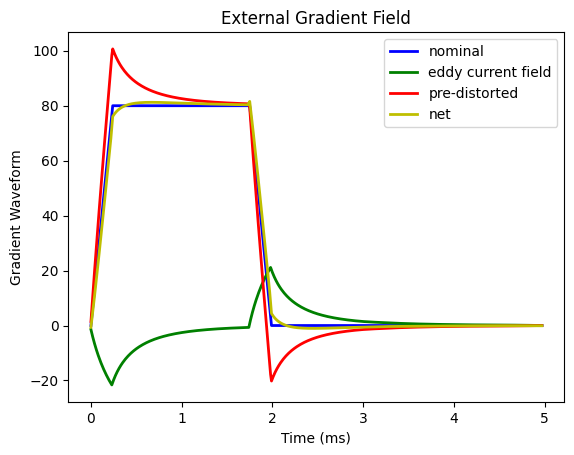

In [25]:
B_preemph = B_ext_norm - B0_eddy
S_preemph = np.diff(B_preemph)

# Convolve with external magnetic field to simulate eddy currents
B_preemph_eddy = np.convolve(-S_preemph, eps, mode='full')
B_preemph_net = B_preemph_eddy + np.pad(B_preemph, (0, len(B_preemph_eddy) - len(B_preemph)))

plt.plot(t_grad_distorted * 1e3, B_ext_norm, 'b', linewidth=2)
plt.plot(t_grad_distorted * 1e3, B0_eddy, 'g', linewidth=2)
plt.plot(t_grad_distorted * 1e3, B_preemph, 'r', linewidth=2)
plt.plot(t_grad_distorted * 1e3, B_preemph_net[0:498], 'y', linewidth=2)

plt.legend(['nominal', 'eddy current field', 'pre-distorted', 'net'])
plt.title('External Gradient Field')
plt.xlabel('Time (ms)')
plt.ylabel('Gradient Waveform')
plt.show()
